## Running MOVE and analyze the latent space

This notebook runs part of the Multi-Omics Variational autoEncoder (MOVE) framework for training the model for integrating the data into the latent space, plotting the results and analyse the important variables for the integration- Before running this code the optimal hyperparameters need to be identified as described in the notebookes <i>MOVE_hyperparameter_optimization_reconstruction.ipynb</i> and <i>MOVE_hyperparameter_optimization_stability.ipynb</i>.

In [1]:
from hydra import initialize, initialize_config_module, initialize_config_dir, compose

from move._utils.data_utils import get_data, merge_configs
from move._training.train import train_model
from move._utils.visualization_utils import embedding_plot_discrete, embedding_plot_float, visualize_training, plot_reconstruction_distribs, visualize_embedding, plot_categorical_importance, plot_continuous_importance
from move._analysis.analysis import get_latents, calc_categorical_reconstruction_acc, calc_continuous_reconstruction_acc, get_embedding, get_pearsonr, get_feature_importance_categorical, get_feature_importance_continuous, save_feat_results, get_feat_importance_on_weights 

/home/valentas/move2/MOVE/src/move/training/train.py:16: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="../conf", config_name="main")


Overriding the default config with configs from data.yaml, model.yaml and training_latent.yaml

Configuration used: 
---
data:
  user_config: data.yaml
  na_value: 'nan'
  raw_data_path: data/
  interim_data_path: data/
  processed_data_path: data/
  version: v1
  ids_file_name: baseline_ids
  categorical_inputs:
  - name: diabetes_genotypes
    weight: 1
  - name: baseline_drugs
    weight: 1
  - name: baseline_categorical
    weight: 1
  continuous_inputs:
  - name: baseline_continuous
    weight: 2
  - name: baseline_transcriptomics
    weight: 1
  - name: baseline_diet_wearables
    weight: 1
  - name: baseline_proteomic_antibodies
    weight: 1
  - name: baseline_target_metabolomics
    weight: 1
  - name: baseline_untarget_metabolomics
    weight: 1
  - name: baseline_metagenomics
    weight: 1
  data_of_interest: baseline_drugs
  categorical_names: ${names:${data.categorical_inputs}}
  continuous_names: ${names:${data.continuous_inputs}}
  categorical_weights: ${weights:${data.c

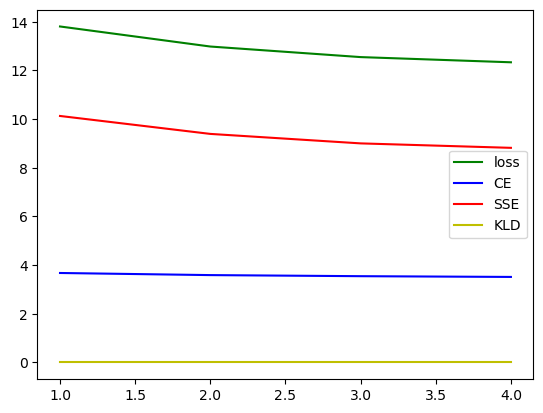

====> Test set loss: 12.0385


<Figure size 640x480 with 0 Axes>

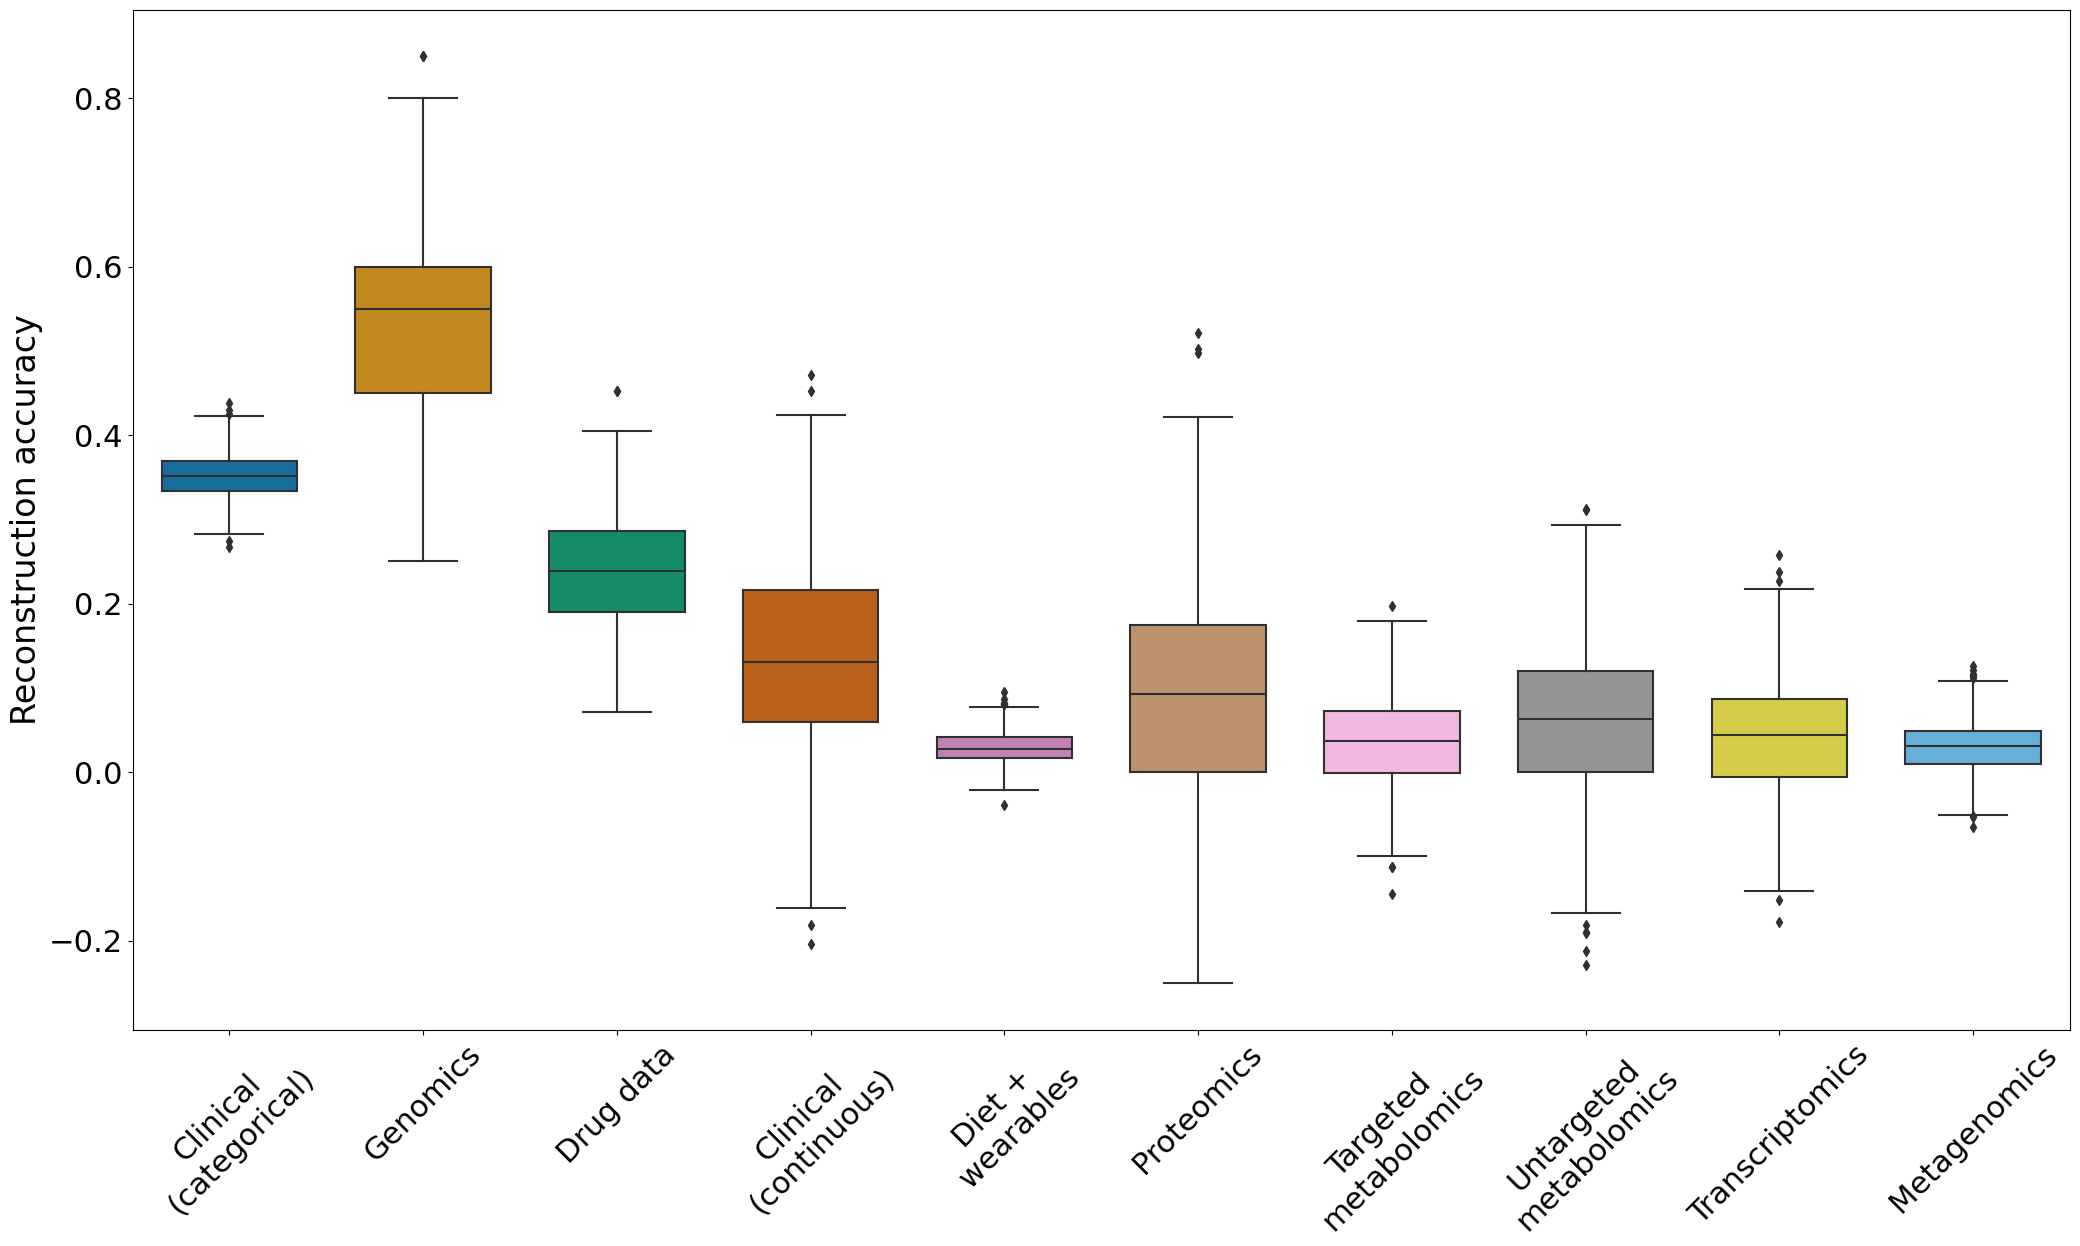


 Getting the embeddings.


  0%|                                                    | 0/20 [00:00<?, ?it/s]

====> Test set loss: 12.0165


  0%|                                                    | 0/42 [00:00<?, ?it/s]

====> Test set loss: 12.0409


  0%|                                                  | 0/8055 [00:00<?, ?it/s]

====> Test set loss: 11.9975


  0%|                                                  | 0/8055 [00:00<?, ?it/s]

====> Test set loss: 11.9770


1179
40
210


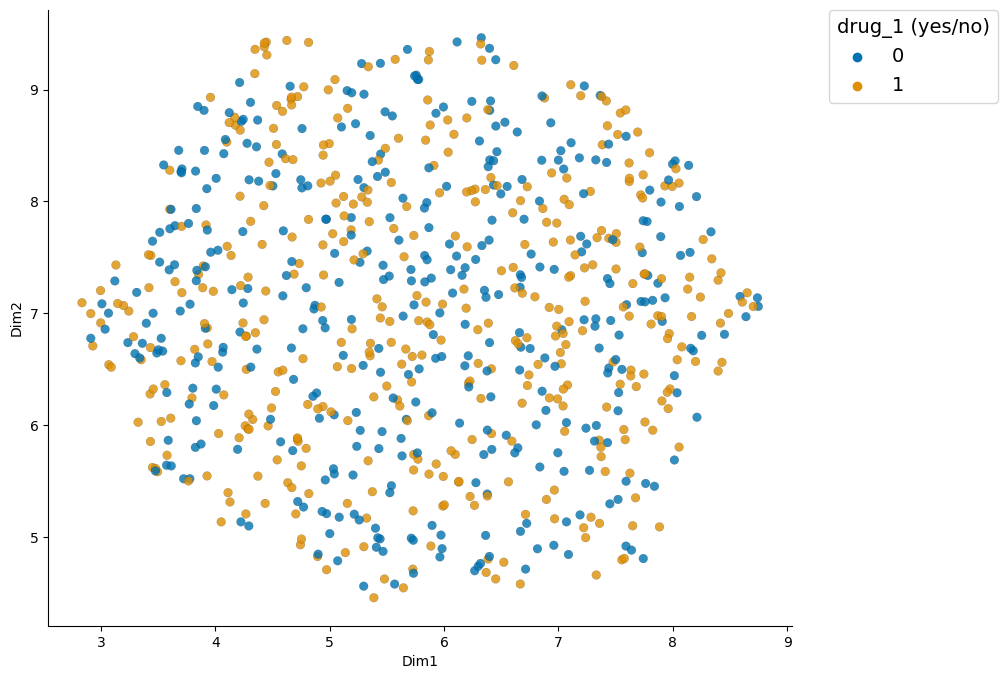

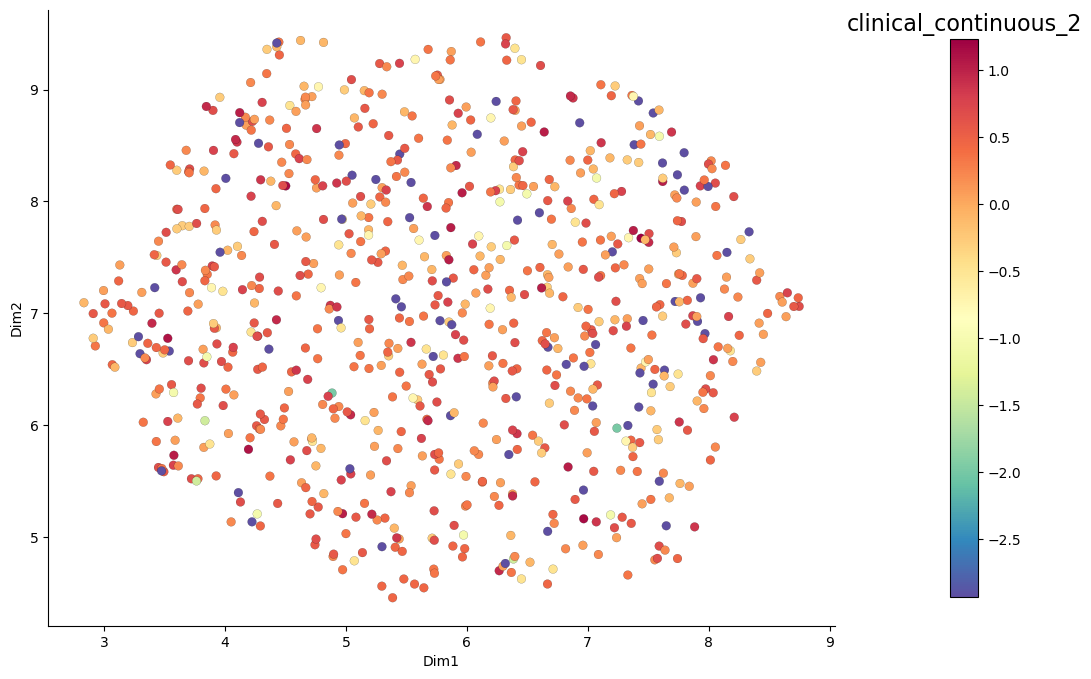

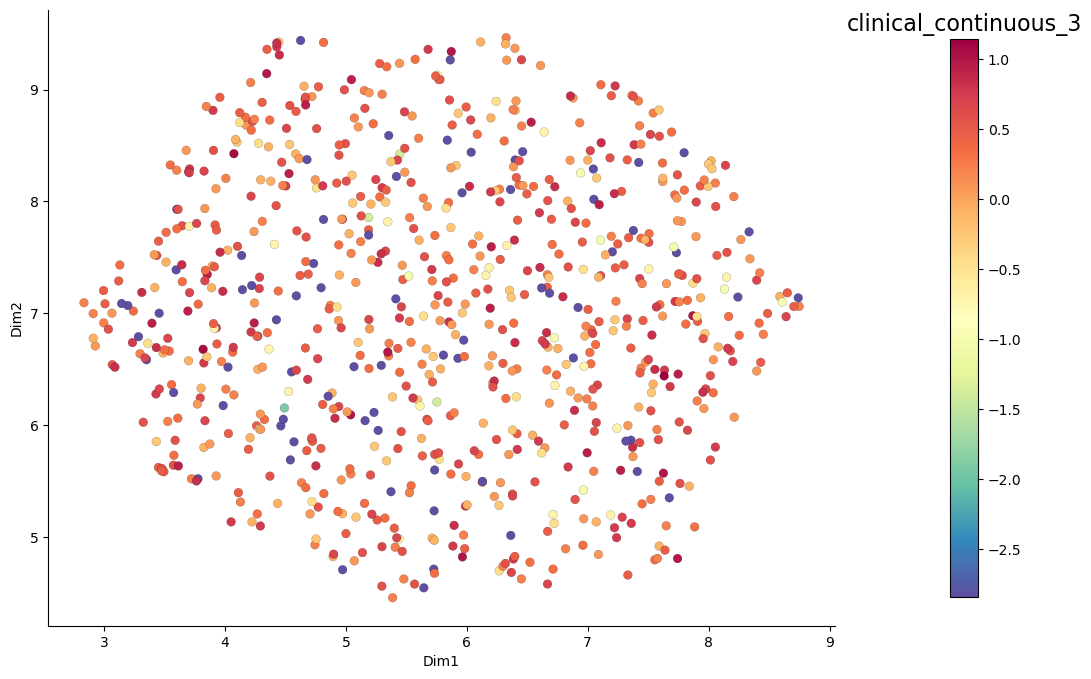

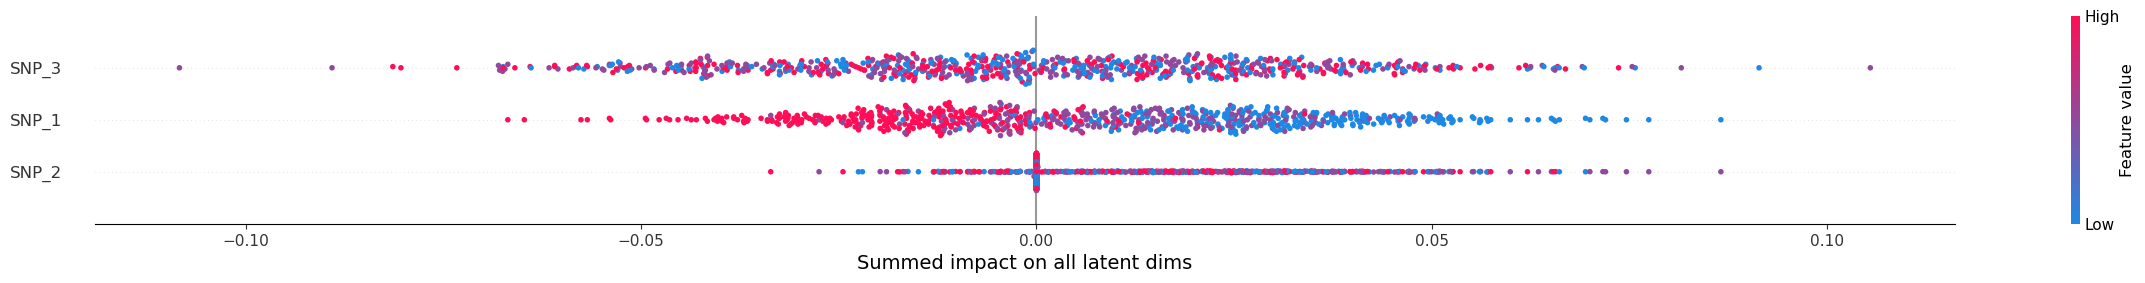

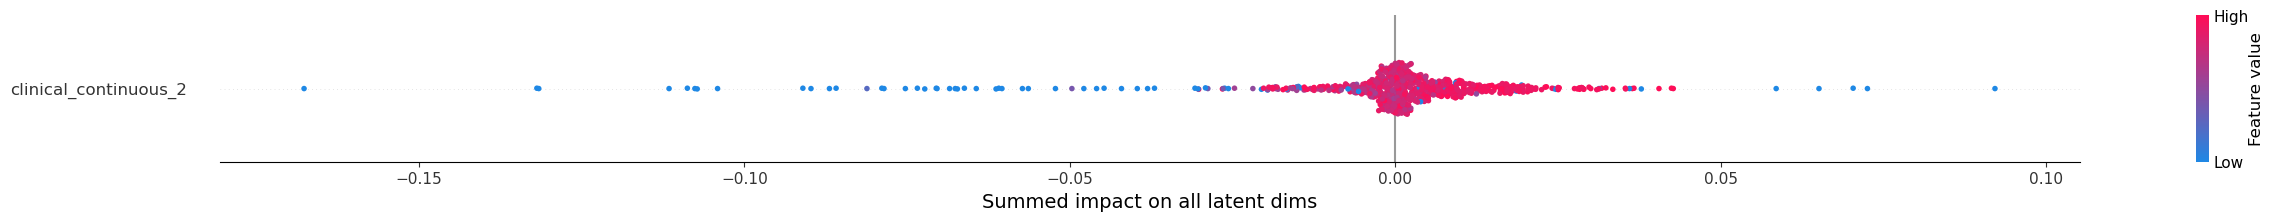

In [3]:
# Initializing the default config 
with initialize(version_base=None, config_path="src/move/conf"):
    base_config = compose(config_name="main")

def main(base_config=base_config): 
    # Merging the user defined data.yaml, model.yaml and training_latent.yaml 
    # with the base_config to override it.
    print('Overriding the default config with configs from data.yaml, model.yaml and training_latent.yaml')
    cfg = merge_configs(base_config=base_config, 
                config_types=['data', 'model', 'training_latent'])
    
    #Getting the variables used in the notebook
    path = cfg.data.processed_data_path
    data_of_interest = cfg.data.data_of_interest
    categorical_names = cfg.data.categorical_names
    continuous_names = cfg.data.continuous_names
    categorical_weights = cfg.data.categorical_weights
    continuous_weights = cfg.data.continuous_weights    
    
    cuda = cfg.model.cuda   
    lrate = cfg.model.lrate
    kld_steps = cfg.model.kld_steps
    batch_steps = cfg.model.batch_steps

    nHiddens = cfg.training_latent.num_hidden
    nLatents = cfg.training_latent.num_latent
    nLayers = cfg.training_latent.num_layers
    nDropout = cfg.training_latent.dropout
    nBeta = cfg.training_latent.beta
    batch_sizes = cfg.training_latent.batch_sizes
    nepochs = cfg.training_latent.tuned_num_epochs 
    
    epochs = range(1, nepochs + 1)    

    #Getting the data
    cat_list, con_list, cat_names, con_names, headers_all, drug, drug_h = get_data(path, categorical_names, continuous_names, data_of_interest)
    
    # Training the model 
    print('Beginning training the model.\n')
    best_model, losses, ce, sse, KLD, train_loader, mask, kld_w, cat_shapes, con_shapes, best_epoch = train_model(cat_list, con_list, categorical_weights, continuous_weights, batch_sizes, nHiddens, nLayers, nLatents, nBeta, nDropout, cuda, kld_steps, batch_steps, nepochs, lrate, test_loader=None, patience=None, early_stopping=False)
    print('\nFinished training the model.')
    
    # Visualizing the training
    visualize_training(path, losses, ce, sse, KLD, epochs)
    
    # Getting the reconstruction results
    latent, latent_var, cat_recon, cat_class, con_recon, loss, likelihood = get_latents(best_model, train_loader, 1)
    cat_total_recon = calc_categorical_reconstruction_acc(cat_shapes, cat_class, cat_recon)
    all_values = calc_continuous_reconstruction_acc(con_shapes, con_recon, train_loader)
    
    # Plotting the reconstruction distributions   
    plot_reconstruction_distribs(path, cat_total_recon, all_values)
    
    # Getting the embeddings
    print('\n Getting the embeddings.')    
    embedding = get_embedding(path, latent)
    
    # Visualizing the embedding of three example features
    visualize_embedding(path, 'categorical', "drug_1", embedding, 
                        mask, cat_list, con_list, cat_names, con_names)
    visualize_embedding(path, 'continuous', "clinical_continuous_2", embedding, 
                        mask, cat_list, con_list, cat_names, con_names) 
    visualize_embedding(path, 'continuous', "clinical_continuous_3", embedding, 
                        mask, cat_list, con_list, cat_names, con_names)    
     
    # Getting pearson correlations of two example features
    get_pearsonr('categorical', "drug_1", embedding, cat_list, con_list, cat_names, con_names)
    get_pearsonr('continuous', "clinical_continuous_2", embedding, cat_list, con_list, cat_names, con_names)
    
    # Getting features importance measures
    all_diffs, all_diffs_cat_np, sum_diffs_cat_np, sum_diffs_cat_abs_np,\
        total_diffs_cat_np = get_feature_importance_categorical(best_model, train_loader, latent)
    all_diffs_con_np, sum_diffs_con_np, sum_diffs_con_abs_np,\
            total_diffs_con_np = get_feature_importance_continuous(best_model, train_loader, mask, latent)

    # Saving features importance measure results 
    save_feat_results(path, all_diffs_cat_np, sum_diffs_cat_np, sum_diffs_cat_abs_np, total_diffs_cat_np, 
                 all_diffs_con_np, sum_diffs_con_np,sum_diffs_con_abs_np, total_diffs_con_np)
    
    # Plotting categorical importance measures
    plot_categorical_importance(path=path,
                            sum_diffs=sum_diffs_cat_np,
                            cat_list=cat_list,
                            feature_names=cat_names,
                            fig_name='importance_SHAP_cat')
    
    # Plotting continuous importance measures
    plot_continuous_importance(path=path,
                           train_loader=train_loader,
                           sum_diffs=sum_diffs_con_np,
                           feature_names=con_names,
                           fig_name='importance_SHAP_con')
    
    # Getting feature importance on weights
    get_feat_importance_on_weights(path, best_model, train_loader, cat_names, con_names)


if __name__ == "__main__":
    main()

Read in the data processed by <i>encode_data.ipynb</i>

Initialize varriables and make model using the identified optimal hyperparameters from the optimzsation steps. Here using equal weight for all continuous but double weight on the clinical data to ensure sufficient learning and focus of the structure of interested (Type 2 Dieabetes). 

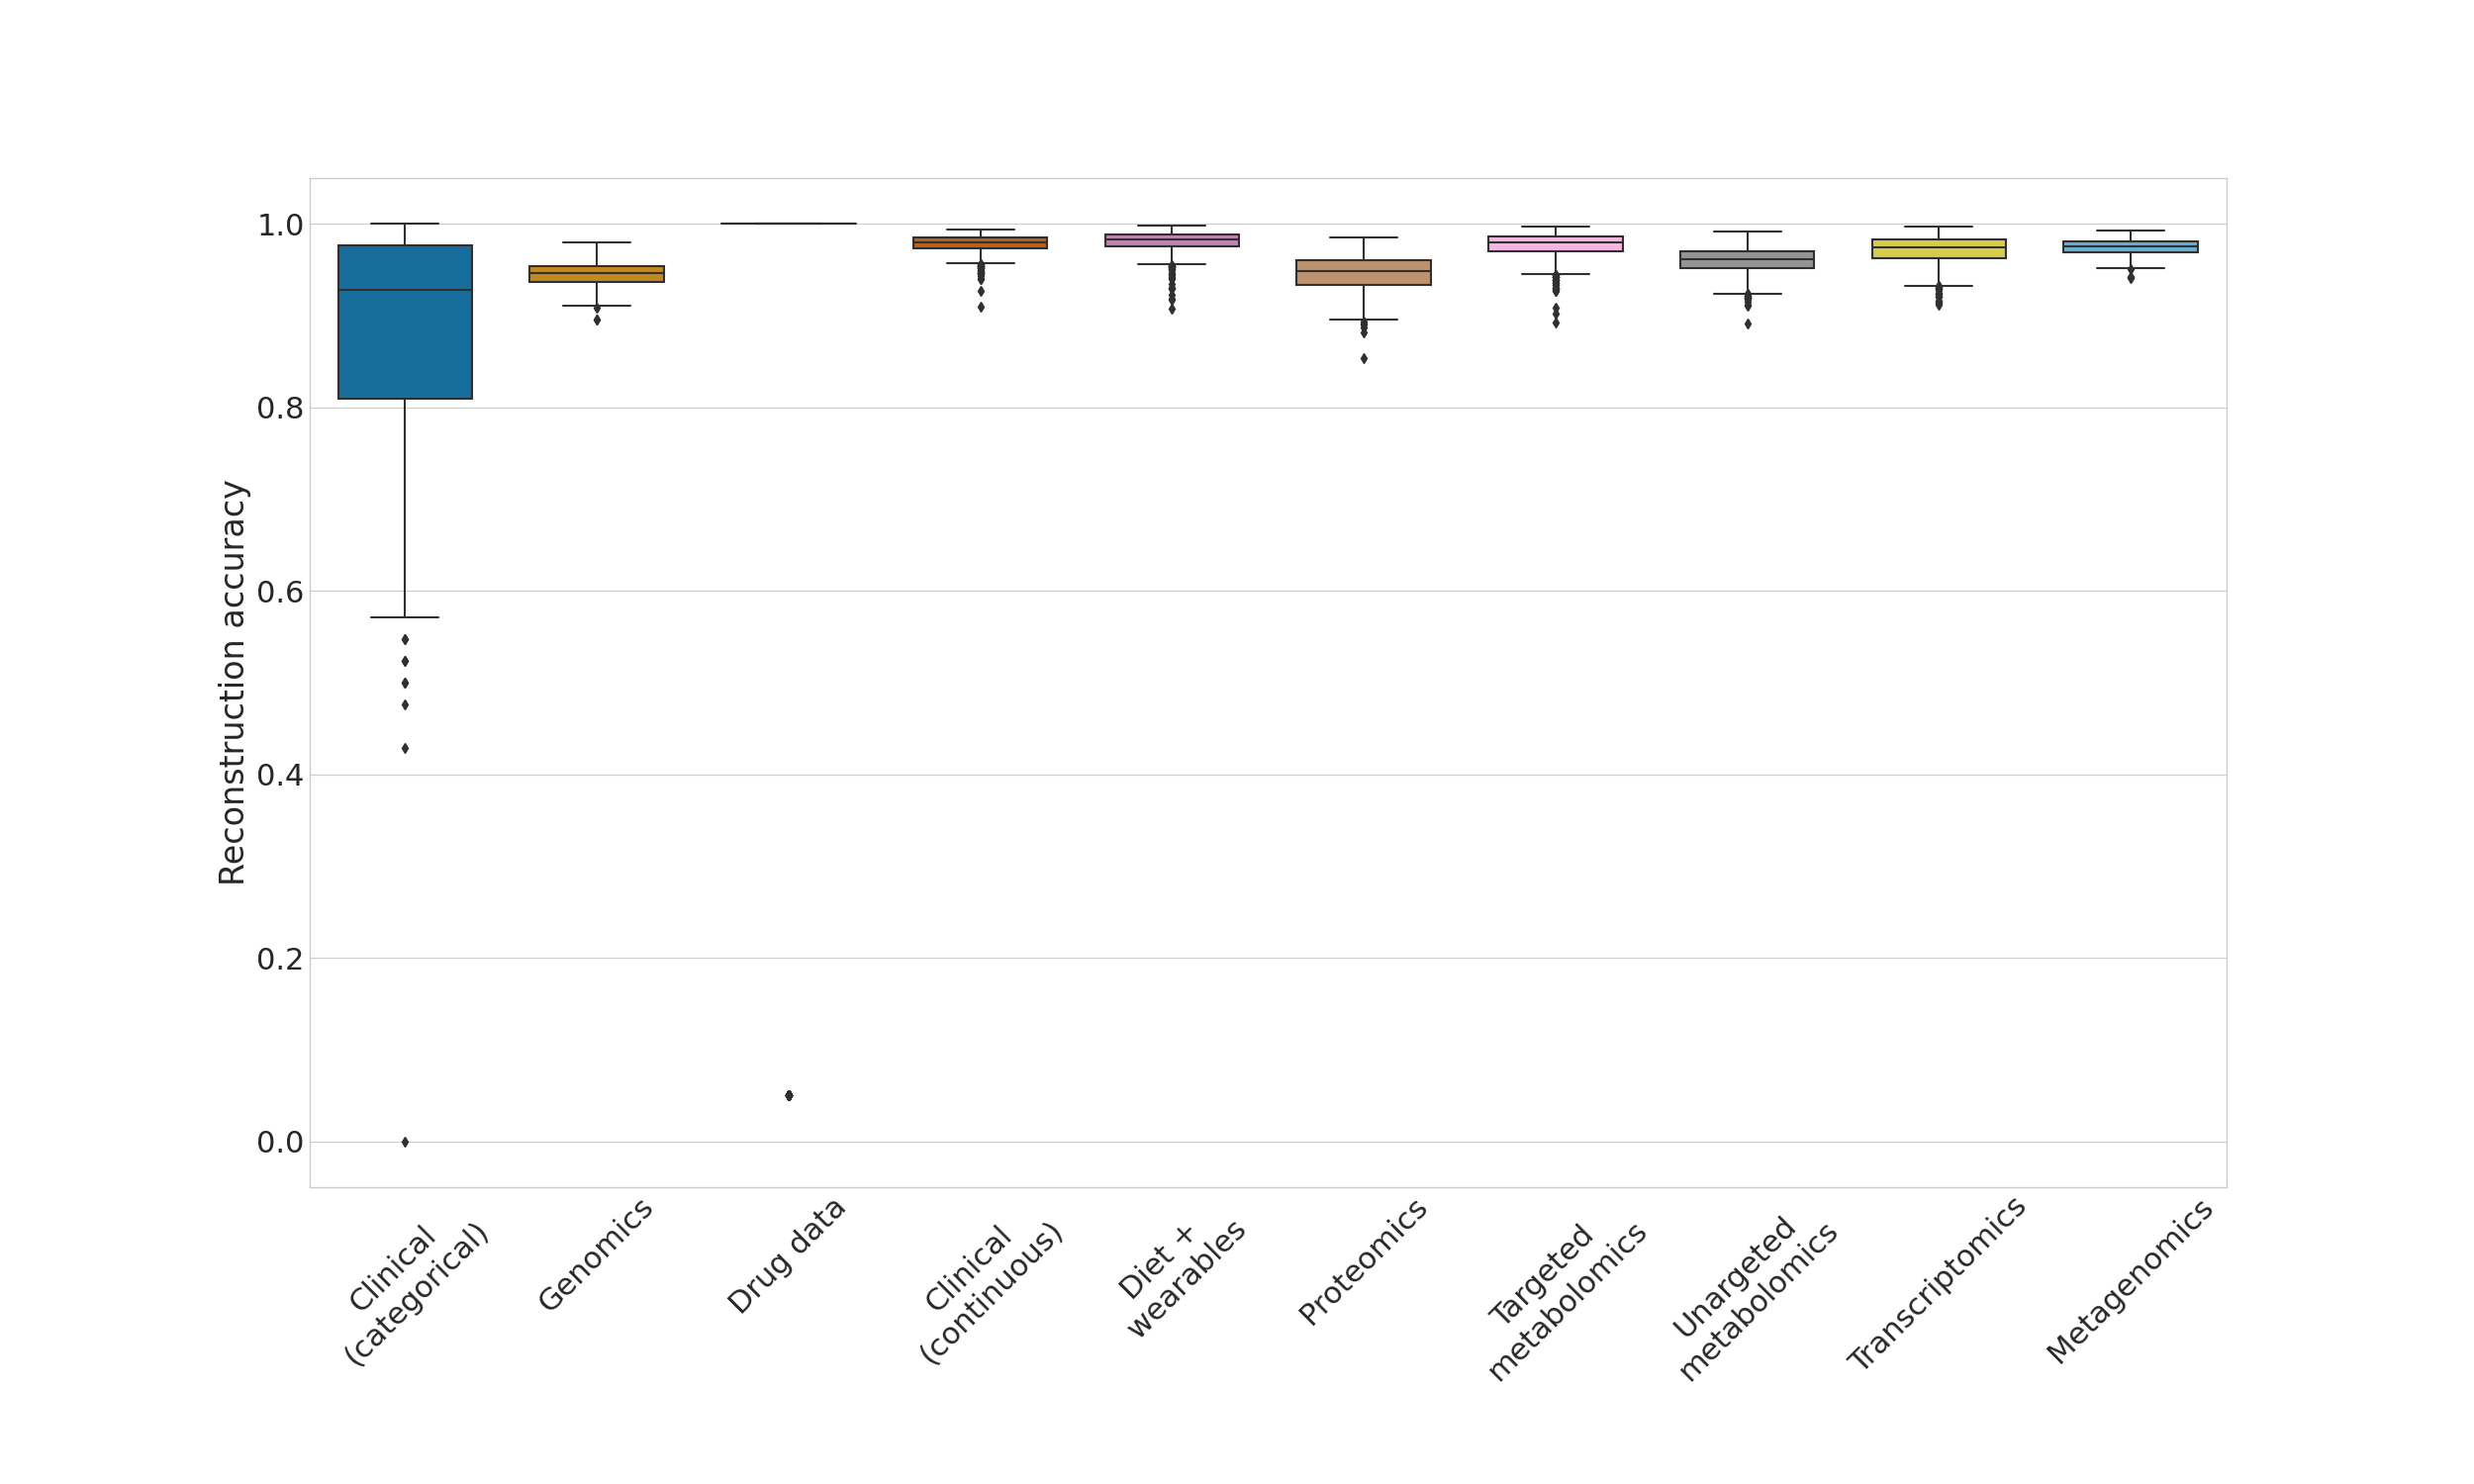

We can now plot the distributions of the features in the latent space in an UMAP embedding.  

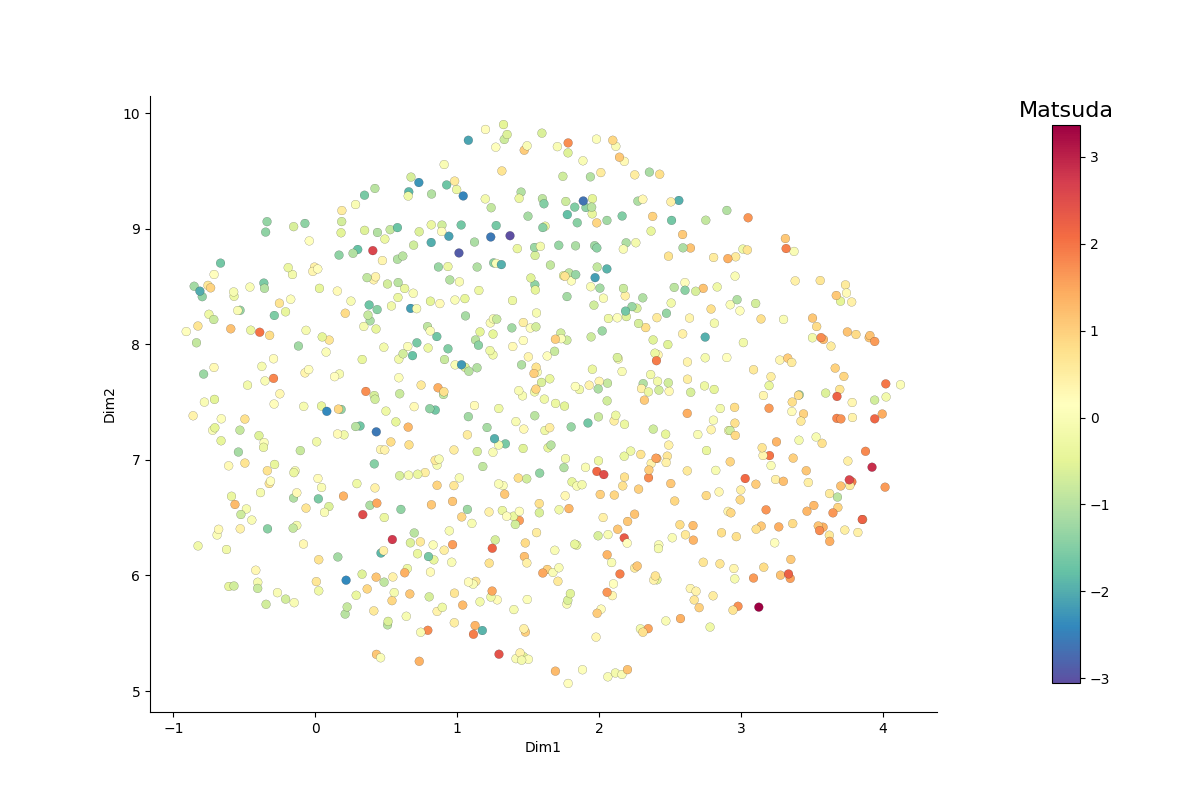

Feature importance inspired by SHAP by changing one variable at the time to missing and calculate change in the latent space. 

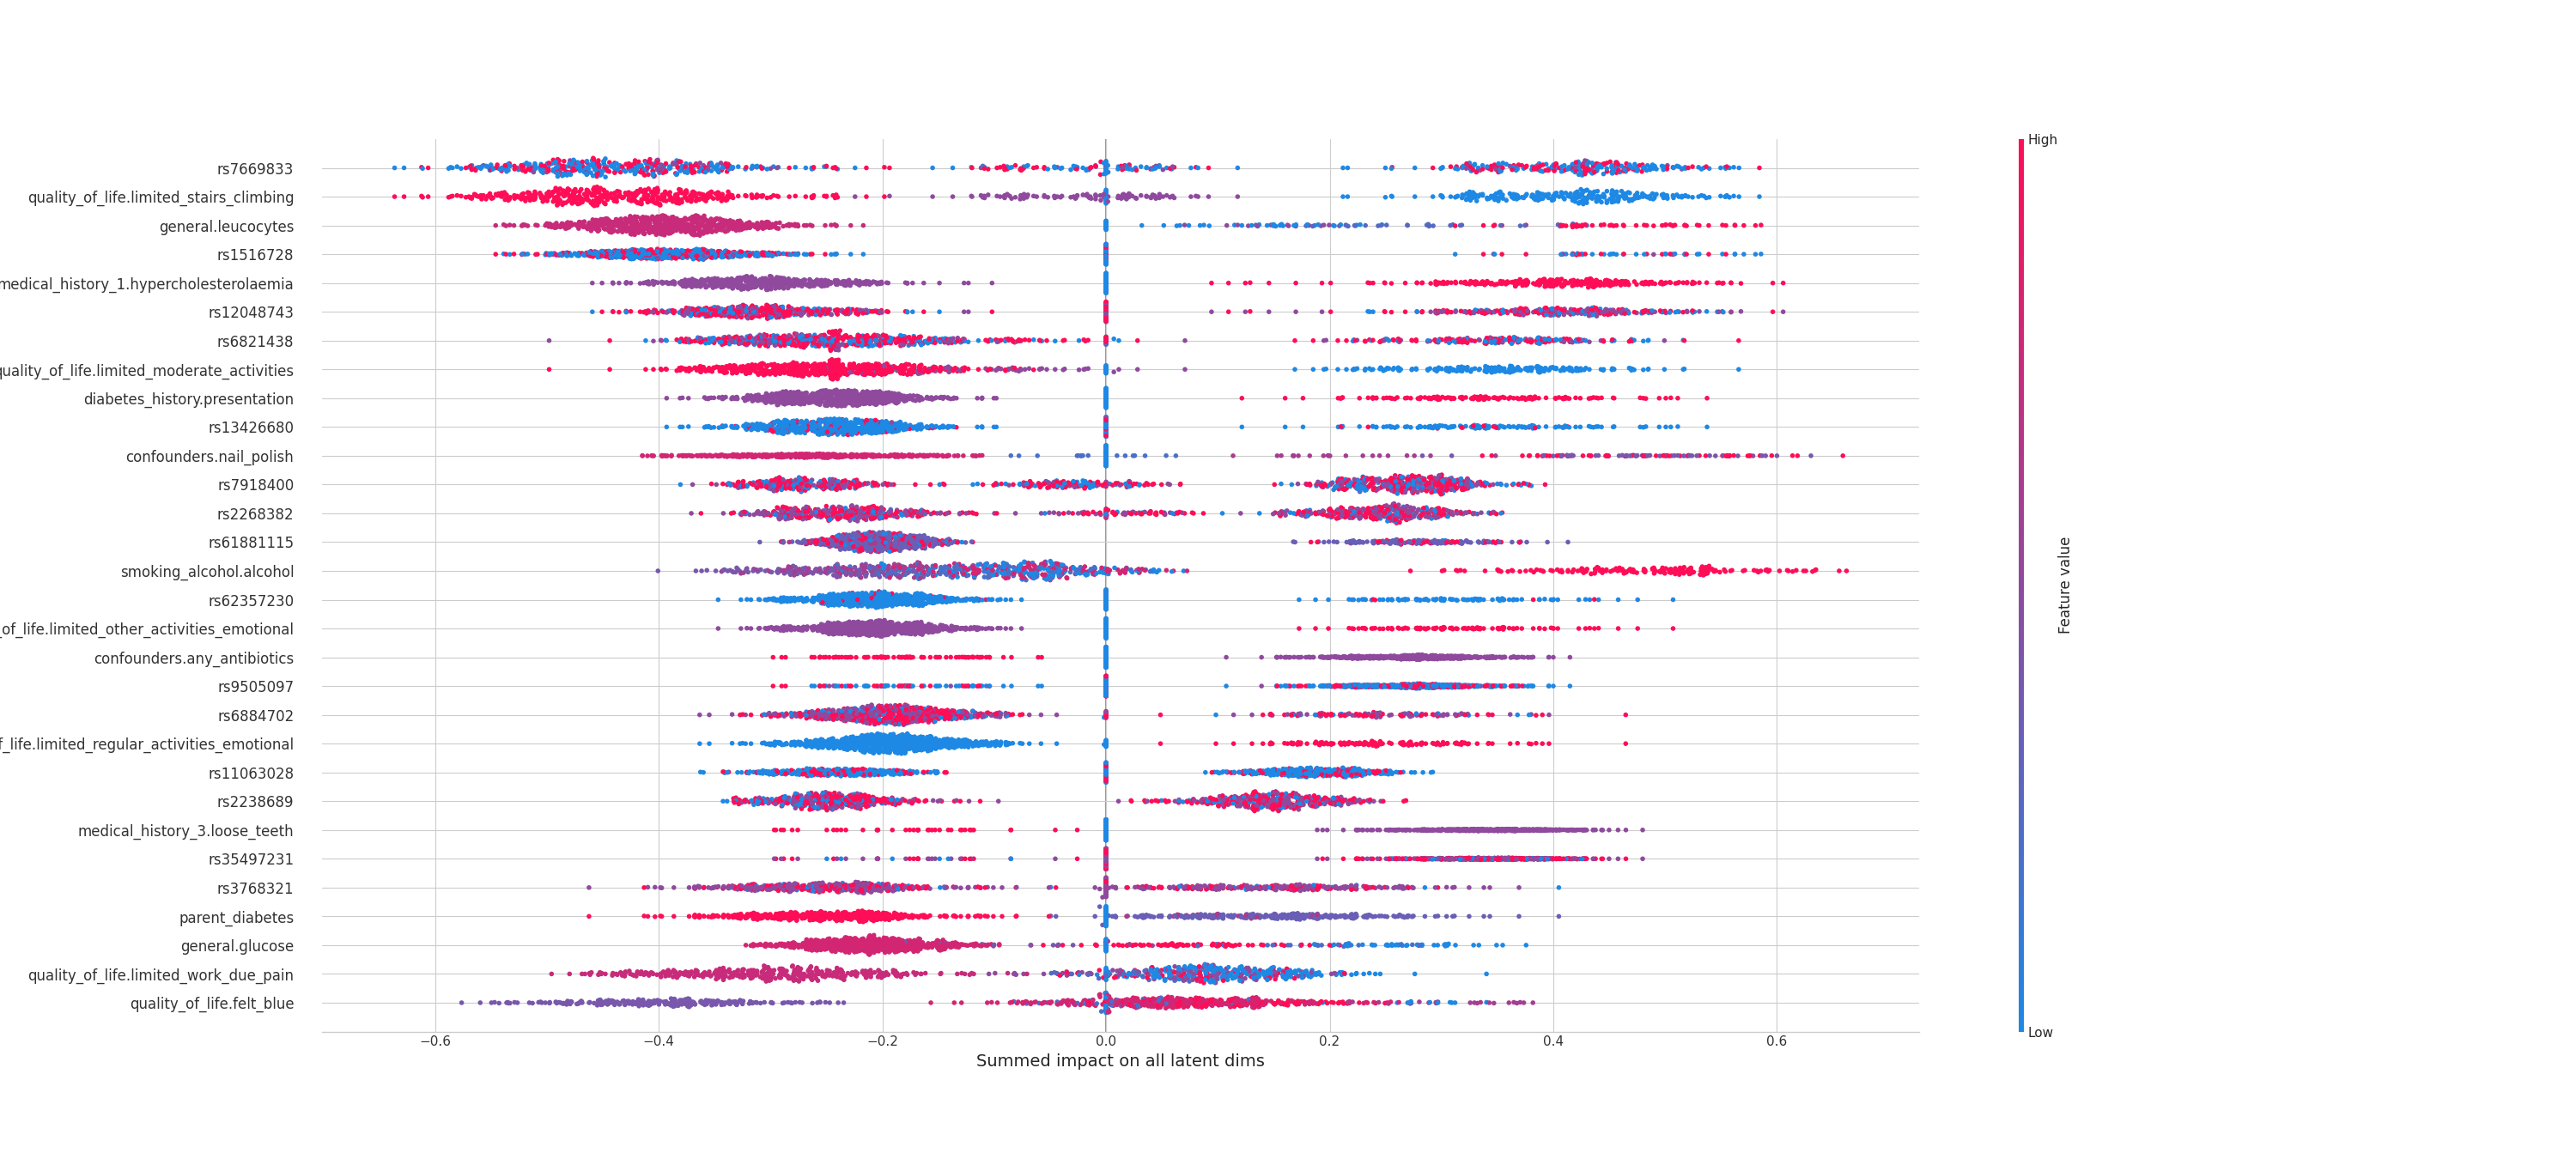

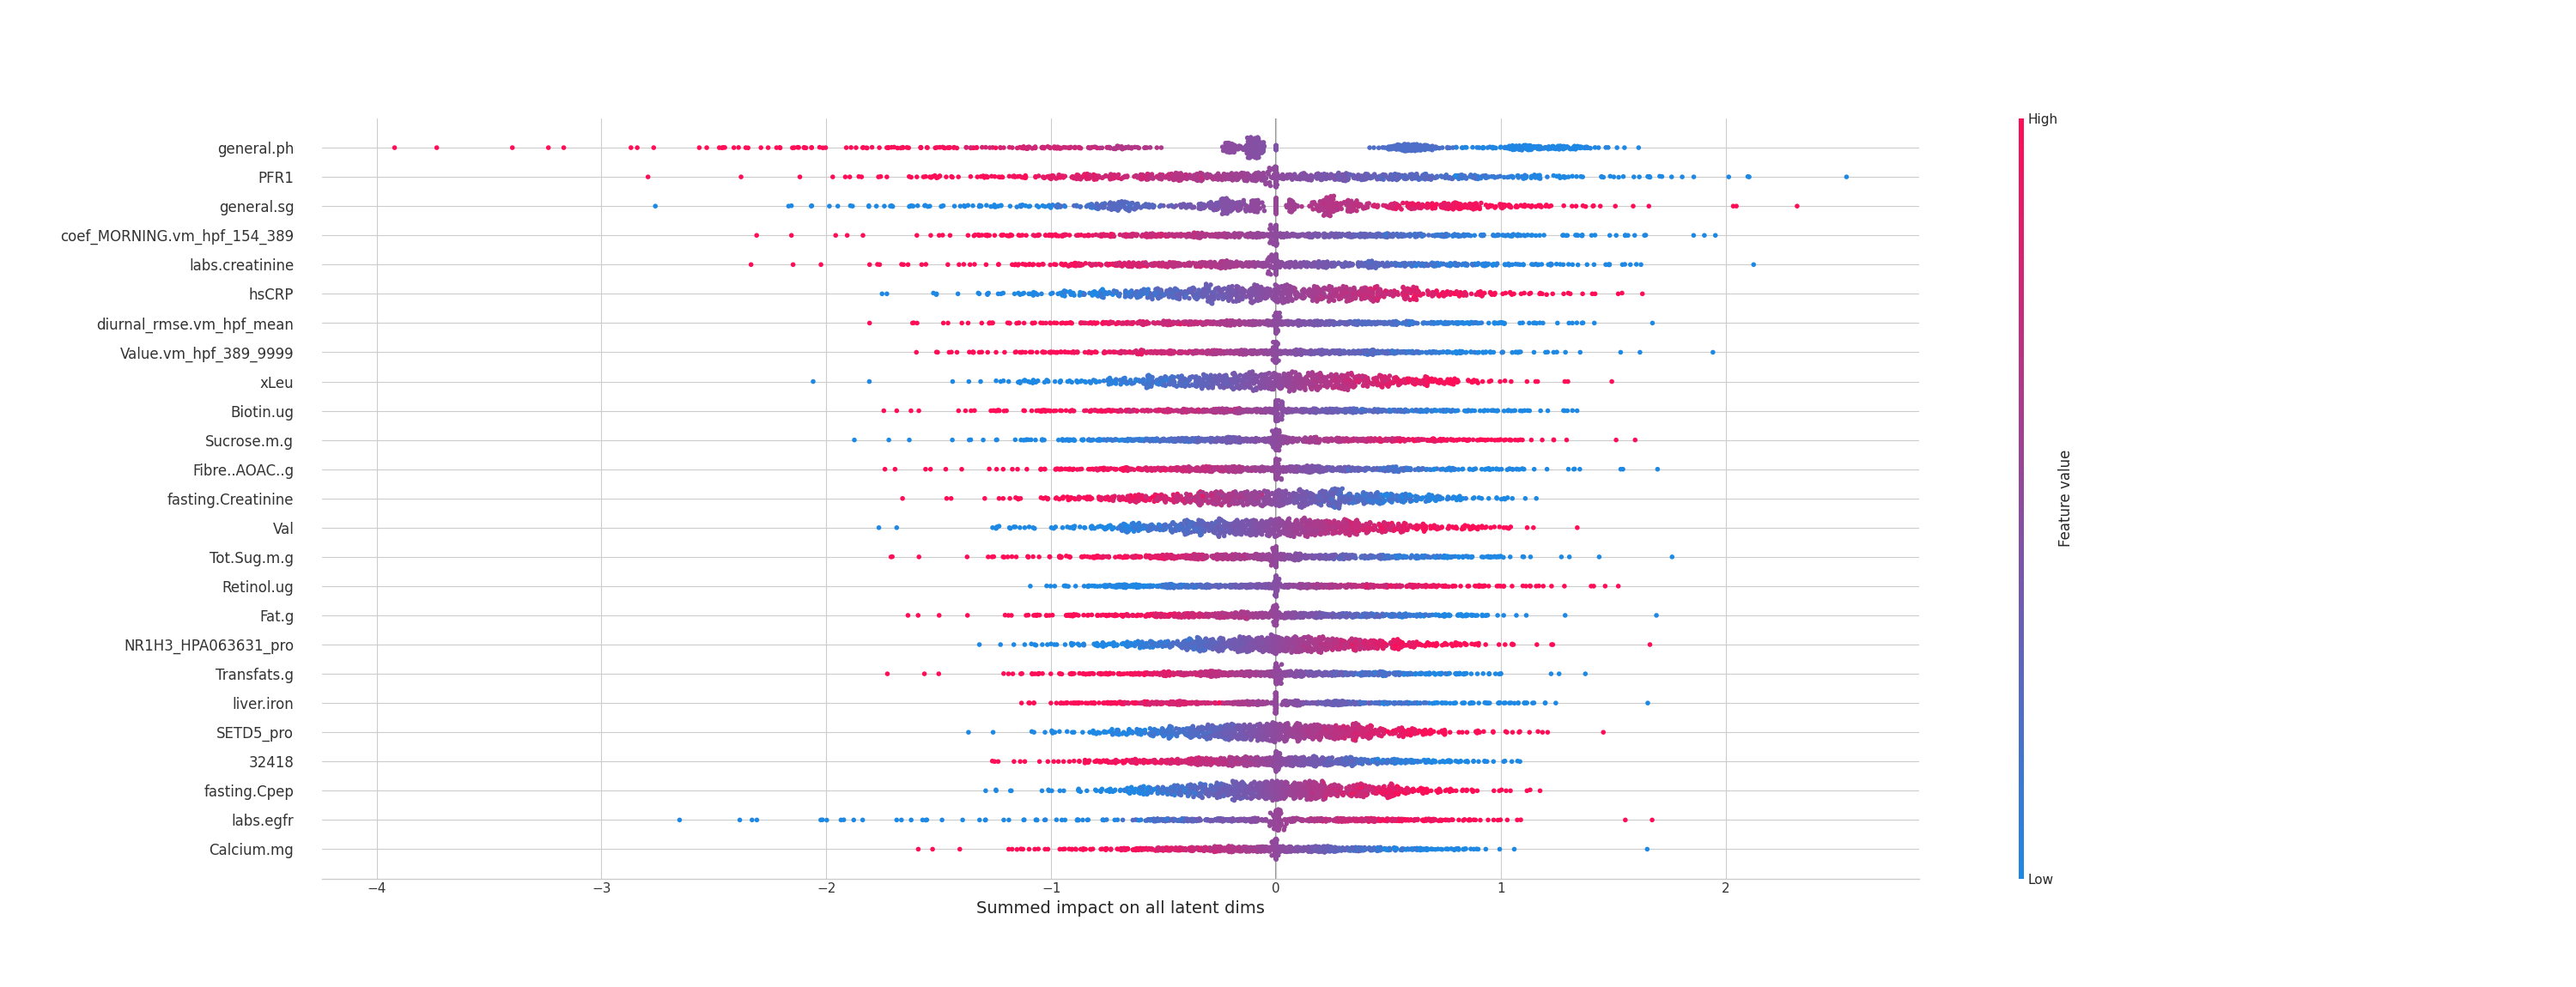

We also calculated the importance based on the weights from input to the first layer. This only represent the importance for defining the latent space (the encoder part). This was ony directy possible because our optimal setting only included one hidden layer. The categorical data is a sum of each input from the flatten one-hot encoding.

After this the <i>identify_drug_assosiation.ipynb</i> can be run for extracting assosiations learned by the networks